<a href="https://colab.research.google.com/github/Criss1941/CSharp-GradeBookApplication/blob/master/N8_Introduction_to_NN_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N8 Neural Network Training 5/12/2022

N8 website: https://n8cir.org.uk/events/introduction-machine-learning-python/
Zoom: TBC
Etherpad: https://pad.carpentries.org/2022-12-05-n8-neural-networks
Content: https://carpentries-incubator.github.io/machine-learning-neural-python/
Slides: https://github.com/tompollard/temp/blob/main/carpentries_ml_intro.pdf
Link to Google Colab - https://colab.research.google.com/

Agenda
- Chest X-rays
- Classification
- Neural networks



In [ ]:
## !wget https://www.dropbox.com/s/qbt6rcwglok3xpw/chest_xrays.zip
## !unzip chest_xrays.zip

#INTRODUCTION

Defining folder locations ready for referencing later.

In [5]:
from glob import glob
import os

# Define folders containing images
data_path = os.path.join("chest_xrays")
effusion_path = os.path.join(data_path, "effusion", "*.png")
normal_path = os.path.join(data_path, "normal", "*.png")

# Create list of files
effusion_list = glob(effusion_path)
normal_list = glob(normal_path)

print('Number of cases with pleural effusion: ', len(effusion_list)) 
print('Number of normal cases: ', len(normal_list))

Number of cases with pleural effusion:  350
Number of normal cases:  350


# VISUALISATION

The below code picks a normal and effusion xray at random and plots it with X & Y axis for allow for coordinate observations.

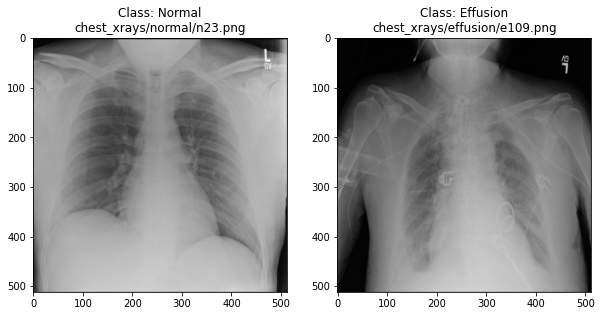

In [6]:
# cv2 is openCV, a popular computer vision library
import cv2
from matplotlib import pyplot as plt 
import random

def plot_example(example, label, loc):
    image = cv2.imread(example)
    im = ax[loc].imshow(image)
    title = f"Class: {label}\n{example}"
    ax[loc].set_title(title)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 10)

# Plot a "normal" record
plot_example(random.choice(normal_list), "Normal", 0)

# Plot a record labelled with effusion
plot_example(random.choice(effusion_list), "Effusion", 1)

Random check for user - selects an image at random and allows user to give an opinion. Solution revealed in folloiwing line.

Effusion or not?


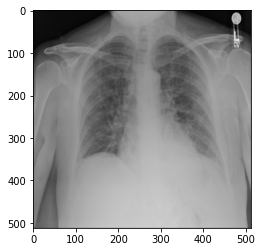

In [7]:
print("Effusion or not?")

# flip a coin
Eff_Nor = random.choice(["Effusion", "Normal"])
if Eff_Nor == "Normal":
    fn = random.choice(normal_list)
else:
    fn = random.choice(effusion_list)

# plot the image
image = cv2.imread(fn)
plt.imshow(image)

In [8]:
print(f"The answer is: {Eff_Nor}!")

The answer is: Effusion!


My results:
1. Normal - incorrect
2. Normal - correct
3. Effusion - correct
4. Effusion - correct
5. Effusion - correct
6. Normal - correct
7. Effusion - correct
8. Normal - incorrect
9. Normal - correct
10. Normal - correct

Accuracy = (8/10)*100 = 80%


Shows image dimensions: H x W x Colour Type

In [9]:
import numpy as np 

file_idx = 100
example = normal_list[file_idx]
image = cv2.imread(example)

print(image.shape)

(512, 512, 3)


To force a black and white (greyscale - H x W) image you can load it as the following:

In [10]:
image = cv2.imread(example, cv2.IMREAD_GRAYSCALE)
print(image.shape)

(512, 512)


Taking an section of the image we can grab the grayscale values for each pixel.

In [18]:
mi_ran = 50
ma_ran = 60
sec_img = image[mi_ran:ma_ran, mi_ran:ma_ran]
print(sec_img)

[[ 58  57  59  60  64  67  67  70  70  70]
 [ 70  73  75  78  75  76  76  76  74  74]
 [ 83  87  85  85  83  81  82  79  78  78]
 [ 90  88  86  81  82  81  80  80  80  81]
 [ 86  84  84  84  85  83  81  82  83  79]
 [ 88  87  86  83  82  80  80  82  79  79]
 [ 90  86  86  85  84  84  84  85  80  84]
 [ 93  92  88  88  88  86  85  82  82  83]
 [ 92  90  93  89  89  91  90  90  85  88]
 [100  96  95  95  96  95  91  91  89  89]]


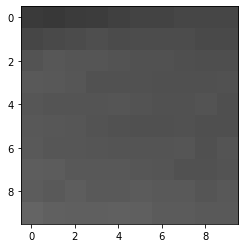

In [19]:
plt.imshow(sec_img, cmap='gray', vmin=0, vmax=255)

## Pre-processing

In the next episode, we’ll be building and training a model. Let’s prepare our data for the modelling phase. For convenience, we’ll begin by loading all of the images and corresponding labels and assigning them to a list.

In [13]:
# create a list of effusion images and labels
dataset_effusion = [cv2.imread(fn, cv2.IMREAD_GRAYSCALE) for fn in effusion_list]
label_effusion = np.ones(len(dataset_effusion))

# create a list of normal images and labels
dataset_normal = [cv2.imread(fn, cv2.IMREAD_GRAYSCALE) for fn in normal_list]
label_normal = np.zeros(len(dataset_normal))

# Combine the lists
dataset = dataset_effusion + dataset_normal
labels = np.concatenate([label_effusion, label_normal])

Let’s also downsample the images, reducing the size from (512, 512) to (256,256).

In [14]:
# Downsample the images from (512,512) to (256,256)
dataset = [cv2.resize(img, (256,256)) for img in dataset]

# Check the size of the reshaped images
print(dataset[0].shape)

# Normalize the data
# Subtract the mean, divide by the standard deviation.
for i in range(len(dataset)):
  dataset[i] = (dataset[i] - np.average(dataset[i], axis= (0, 1))) / np.std(dataset[i], axis= (0, 1)) 

(256, 256)


Finally, we’ll convert our dataset from a list to an array. We are expecting it to be (700, 256, 256). That is 700 images (350 effusion cases and 350 normal), each with a dimension of 256 by 256.

In [15]:
dataset = np.asarray(dataset, dtype=np.float32)
print(f"Matrix Dimensions: {dataset.shape}")

Matrix Dimensions: (700, 256, 256)


We could plot the images by indexing them on dataset, e.g., we can plot the first image in the dataset with:

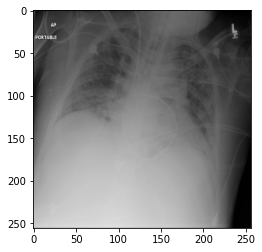

In [16]:
idx = 0
vals = dataset[idx].flatten()
plt.imshow(dataset[idx], cmap='gray', vmin=min(vals), vmax=max(vals))

#DATA PREP

Splits sets into training and testing sets;
- creates datasets and labels
- randomly splits for training, testing, and validation
- prints size(shape) of each dataset

In [17]:
from sklearn.model_selection import train_test_split

# Our Tensorflow model requires the input to be:
# [batch, height, width, n_channels]
# So we need to add a dimension to the dataset and labels.
# 
# Ellipsis (...) is shorthand for selecting with ":" across dimensions. 
# np.newaxis expands the selection by one dimension.
# ONLY RUN ONCE dataset = dataset[..., np.newaxis]
# ONLY RUN ONCE labels = labels[..., np.newaxis]

# Create training and test sets
dataset_train, dataset_test, labels_train, labels_test = train_test_split(dataset, labels, test_size=0.15, random_state=42)

# Create a validation set
dataset_train, dataset_val, labels_train, labels_val = train_test_split(dataset_train, labels_train, test_size=0.15, random_state=42)

print("No. images, x_dim, y_dim, colors) (No. labels, 1)\n")
print(f"Train: {dataset_train.shape}, {labels_train.shape}")
print(f"Validation: {dataset_val.shape}, {labels_val.shape}")
print(f"Test: {dataset_test.shape}, {labels_test.shape}")

No. images, x_dim, y_dim, colors) (No. labels, 1)

Train: (505, 256, 256, 1), (505, 1)
Validation: (90, 256, 256, 1), (90, 1)
Test: (105, 256, 256, 1), (105, 1)


We have a small dataset, which increases the chance of overfitting our model. If our model is overfitted, it becomes less able to generalize to data outside the training data.

To artificially increase the size of our training set, we can use ImageDataGenerator. This function generates new data by applying random transformations to our source images while our model is training

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define what kind of transformations we would like to apply
# such as rotation, crop, zoom, position shift, etc
datagen = ImageDataGenerator(
    rotation_range=3, #rotate the image
    width_shift_range=0, #stretch image - width
    height_shift_range=0, #stretch image - height
    zoom_range=0.5, #zooms in and out of image
    horizontal_flip=False) #flip the image

To plot generated images

Found 700 images belonging to 2 classes.


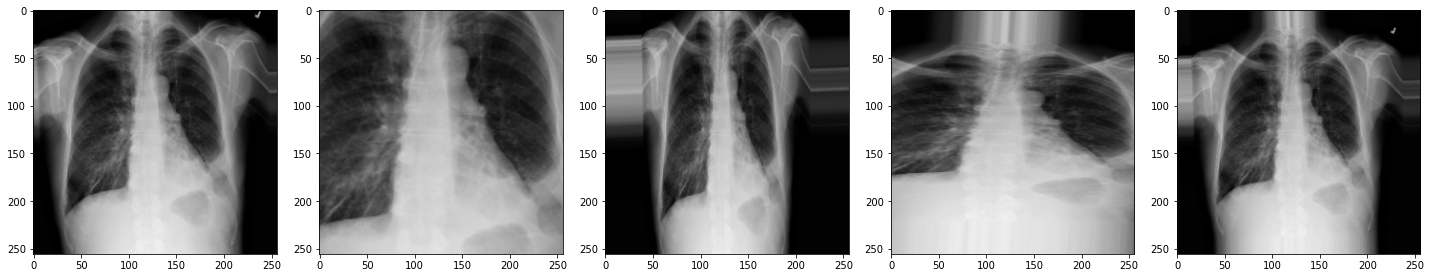

In [33]:
# specify path to source data
path = os.path.join("chest_xrays")
batch_size=5

val_generator = datagen.flow_from_directory(
        path, color_mode="rgb",
        target_size=(256, 256),
        batch_size=batch_size)

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype('uint8'))
    plt.tight_layout()
    plt.show()

augmented_images = [val_generator[0][0][0] for i in range(batch_size)]
plot_images(augmented_images)

#NEURAL NETWORKS

In [35]:
# Create the architecture of our convolutional neural network, using
# the tensorflow library
from tensorflow.random import set_seed
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# set random seed for reproducibility
set_seed(42)
 
# Our input layer should match the input shape of our images.
# A CNN takes tensors of shape (image_height, image_width, color_channels)
# We ignore the batch size when describing the input layer
# Our input images are 256 by 256, plus a single colour channel.
inputs = Input(shape=(256, 256, 1))

# Let's add the first convolutional layer
x = Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(inputs)

# MaxPool layers are similar to convolution layers. 
# The pooling operation involves sliding a two-dimensional filter over each channel of feature map and selecting the max values.
# We do this to reduce the dimensions of the feature maps, helping to limit the amount of computation done by the network.
x = MaxPool2D()(x)

# We will add more convolutional layers, followed by MaxPool
x = Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(filters=12, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(filters=12, kernel_size=5, padding='same', activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(filters=20, kernel_size=5, padding='same', activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(filters=20, kernel_size=7, padding='same', activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(filters=50, kernel_size=7, padding='same', activation='relu')(x)

# Global max pooling reduces dimensions back to the input size
x = GlobalAveragePooling2D()(x)

# Finally we will add two "dense" or "fully connected layers".
# Dense layers help with the classification task, after features are extracted.
x = Dense(128, activation='relu')(x)

# Dropout is a technique to help prevent overfitting that involves deleting neurons.
x = Dropout(0.6)(x)

x = Dense(32, activation='relu')(x)

# Our final dense layer has a single output to match the output classes.
# If we had multi-classes we would match this number to the number of classes.
outputs = Dense(1, activation='sigmoid')(x)

# Finally, we will define our network with the input and output of the network
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 8)       80        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 8)       584       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 12)        876 

#TRAINING

In [38]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the network optimization method. 
# Adam is a popular gradient descent algorithm
# with adaptive, per-parameter learning rates.
custom_adam = optimizers.Adam()

# Compile the model defining the 'loss' function type, optimization and the metric.
model.compile(loss='binary_crossentropy', optimizer=custom_adam, metrics=['acc'])

# Save the best model found during training
checkpointer = ModelCheckpoint(filepath='best_model.hdf5', monitor='val_loss',
                               verbose=1, save_best_only=True)

# Now train our network!
# steps_per_epoch = len(dataset_train)//batch_size
hist = model.fit(datagen.flow(dataset_train, labels_train, batch_size=32), 
                 steps_per_epoch=15, 
                 epochs=15, 
                 validation_data=(dataset_val, labels_val), 
                 callbacks=[checkpointer])

Epoch 1/15
15/15 [==============================] - ETA: 0s - loss: 0.5334 - acc: 0.7484
Epoch 1: val_loss improved from inf to 0.48570, saving model to best_model.hdf5
15/15 [==============================] - 12s 747ms/step - loss: 0.5334 - acc: 0.7484 - val_loss: 0.4857 - val_acc: 0.7889
Epoch 2/15
15/15 [==============================] - ETA: 0s - loss: 0.5202 - acc: 0.7590
Epoch 2: val_loss did not improve from 0.48570
15/15 [==============================] - 11s 731ms/step - loss: 0.5202 - acc: 0.7590 - val_loss: 0.5164 - val_acc: 0.7444
Epoch 3/15
15/15 [==============================] - ETA: 0s - loss: 0.5275 - acc: 0.7484
Epoch 3: val_loss improved from 0.48570 to 0.48085, saving model to best_model.hdf5
15/15 [==============================] - 11s 731ms/step - loss: 0.5275 - acc: 0.7484 - val_loss: 0.4808 - val_acc: 0.8111
Epoch 4/15
15/15 [==============================] - ETA: 0s - loss: 0.4952 - acc: 0.7801
Epoch 4: val_loss improved from 0.48085 to 0.47745, saving model to

To see how accurate the model is we can plot the loss

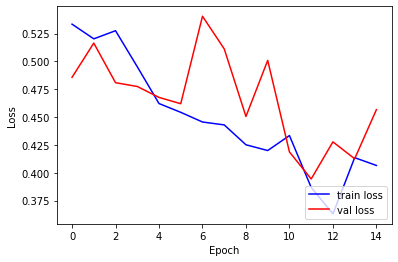

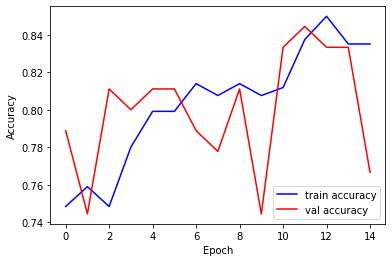

In [39]:
plt.plot(hist.history['loss'], 'b-', label='train loss')
plt.plot(hist.history['val_loss'], 'r-', label='val loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

plt.plot(hist.history['acc'], 'b-', label='train accuracy')
plt.plot(hist.history['val_acc'], 'r-', label='val accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [41]:
from tensorflow.keras.models import load_model 

# Open the best model saved during training
best_model = load_model('best_model.hdf5')
print('\nNeural network weights updated to the best epoch.')
print(f"Accuracy in test group: {best_model.evaluate(dataset_test, labels_test, verbose=0)[1]}")


Neural network weights updated to the best epoch.
Accuracy in test group: 0.8476190567016602


#Explainability

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 855 kB/s 


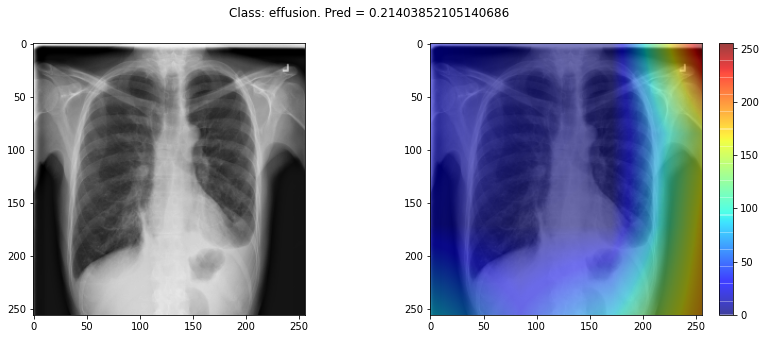

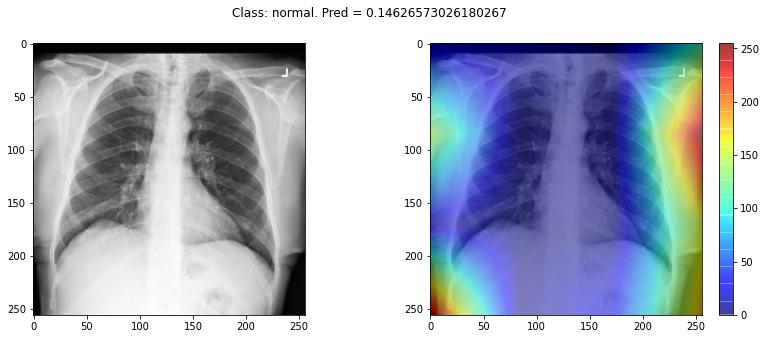

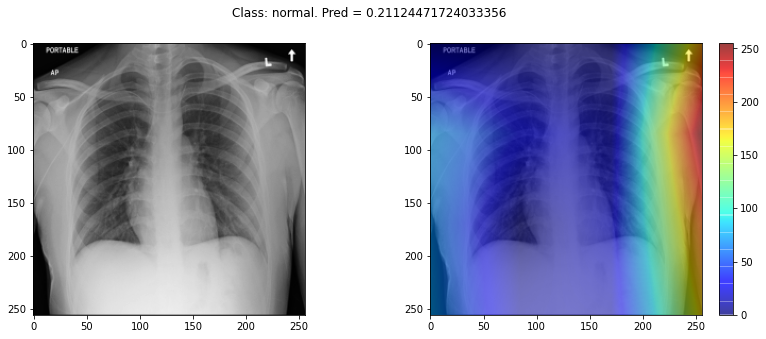

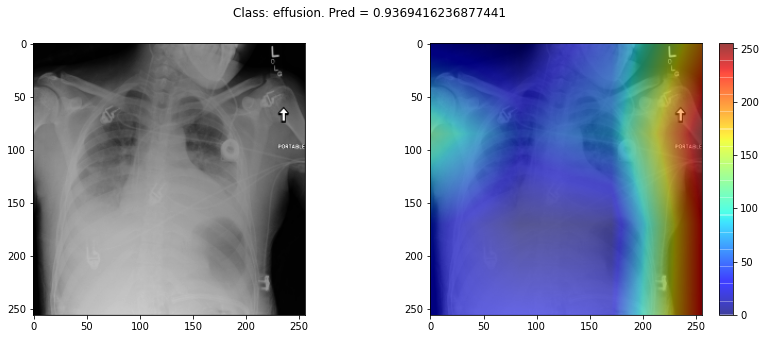

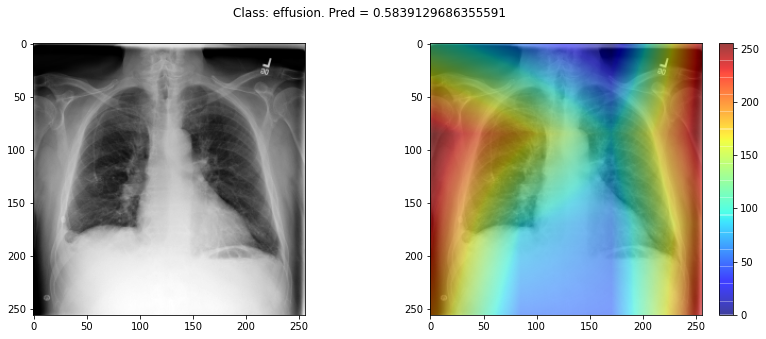

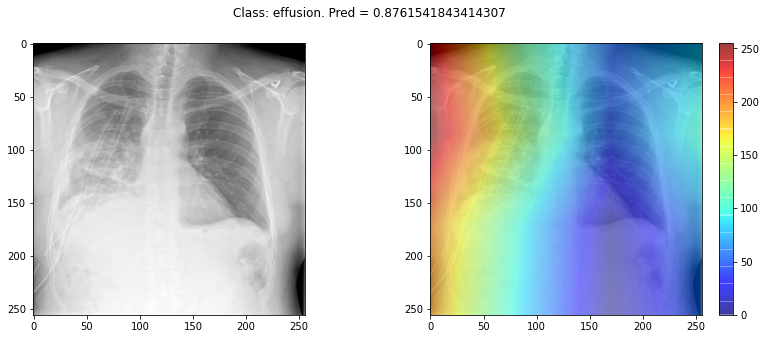

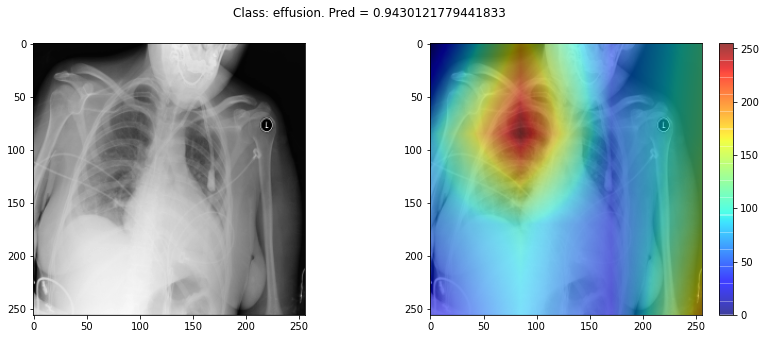

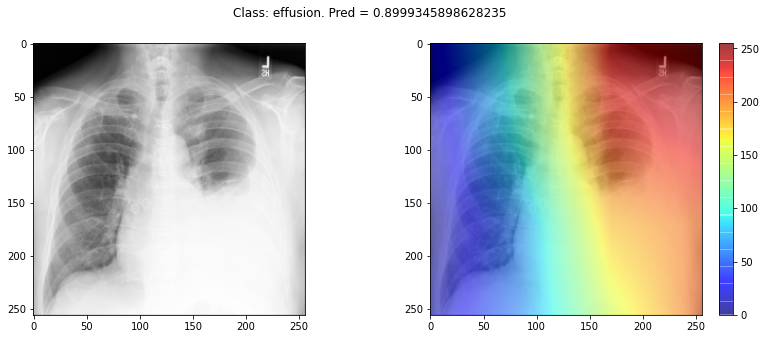

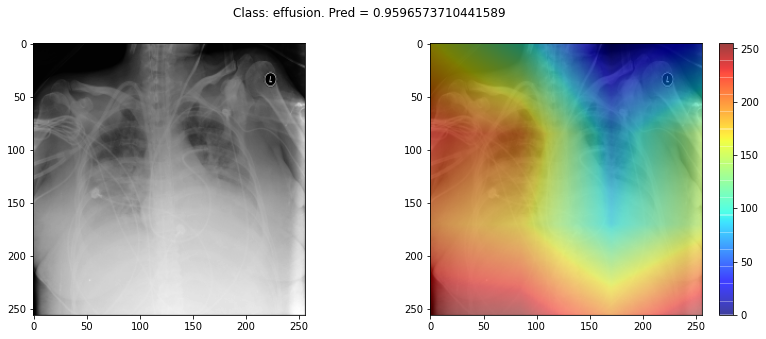

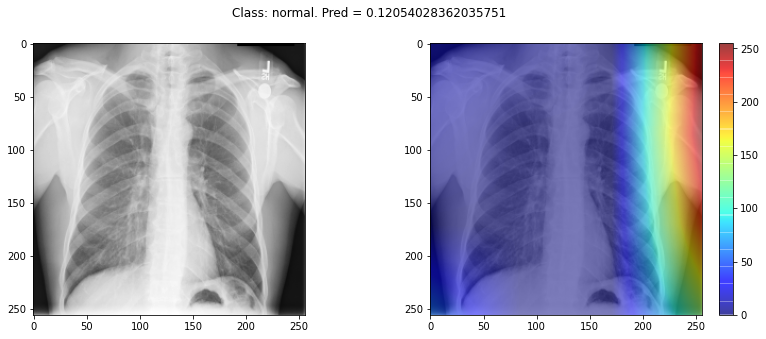

In [42]:
!pip install tf_keras_vis
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

import numpy as np
from matplotlib import pyplot as plt
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils.scores import CategoricalScore

# Select two differing explainability algorithms
gradcam = GradcamPlusPlus(best_model, clone=True)
scorecam = Scorecam(best_model, clone=True)


def plot_map(cam, classe, prediction, img):
    """
    Plot the image.
    """
    fig, axes = plt.subplots(1,2, figsize=(14, 5))
    axes[0].imshow(np.squeeze(img), cmap='gray')
    axes[1].imshow(np.squeeze(img), cmap='gray')
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    i = axes[1].imshow(heatmap, cmap="jet", alpha=0.5)
    fig.colorbar(i)
    plt.suptitle("Class: {}. Pred = {}".format(classe, prediction))

# Plot each image with accompanying saliency map
for image_id in range(10):
    SEED_INPUT = dataset_test[image_id]
    CATEGORICAL_INDEX = [0]

    layer_idx = 18
    penultimate_layer_idx = 13
    class_idx  = 0

    cat_score = labels_test[image_id]
    cat_score = CategoricalScore(CATEGORICAL_INDEX)
    cam = gradcam(cat_score, SEED_INPUT, 
                  penultimate_layer = penultimate_layer_idx,
                  normalize_cam=True)
    
    # Display the class
    _class = 'normal' if labels_test[image_id] == 0 else 'effusion'
    _prediction = best_model.predict(dataset_test[image_id][np.newaxis, :, ...], verbose=0)
    
    plot_map(cam, _class, _prediction[0][0], SEED_INPUT)


Cleaned Sanity Map - Hugh made

2/2 [==============================] - 0s 130ms/step


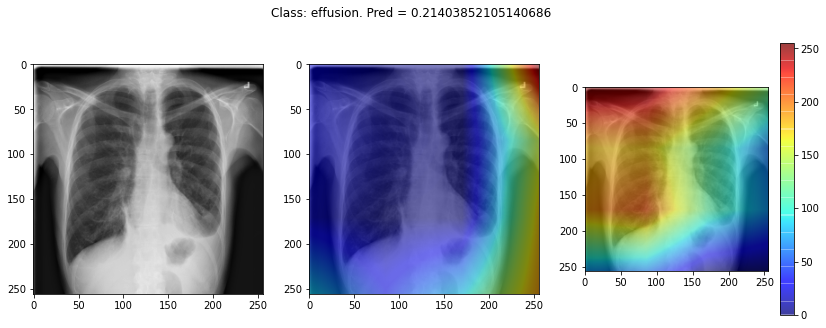

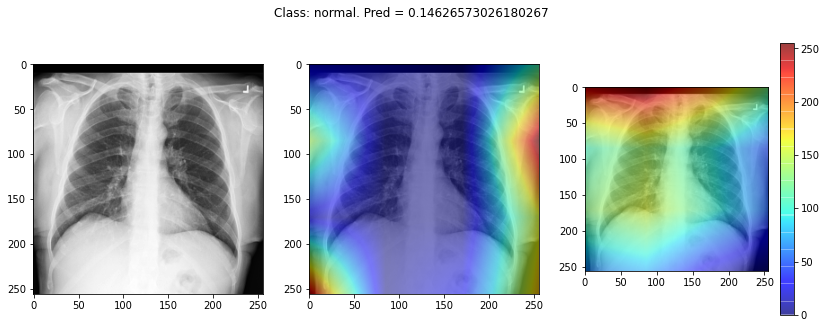

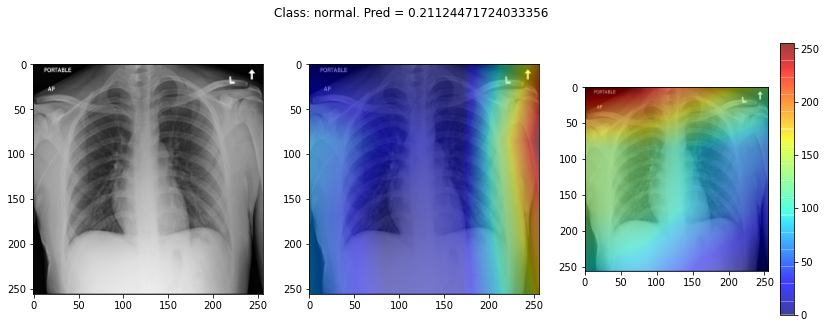

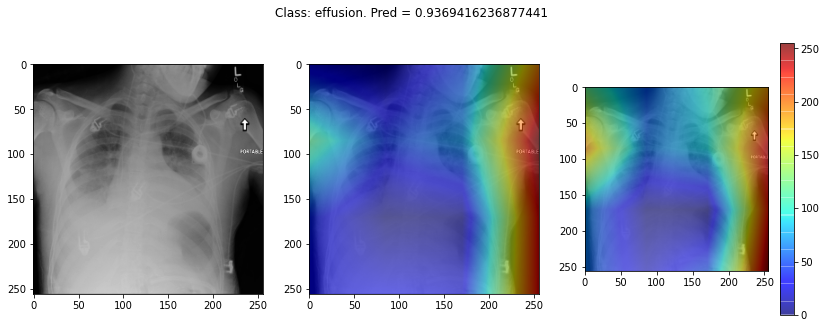

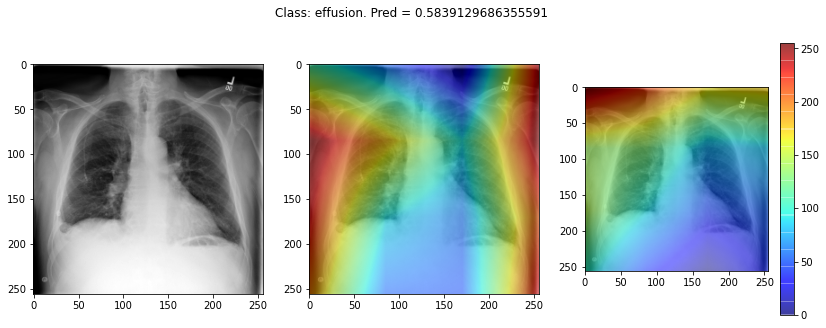

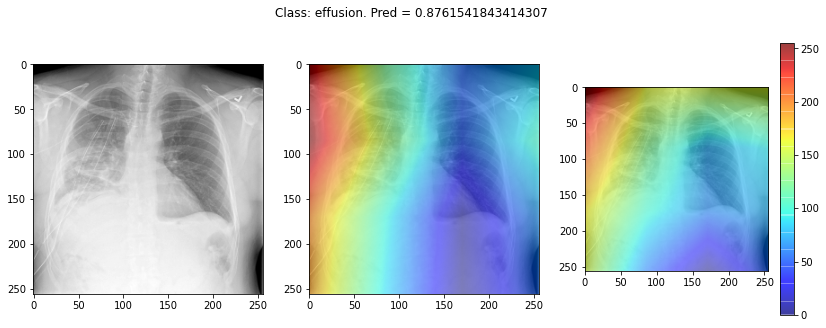

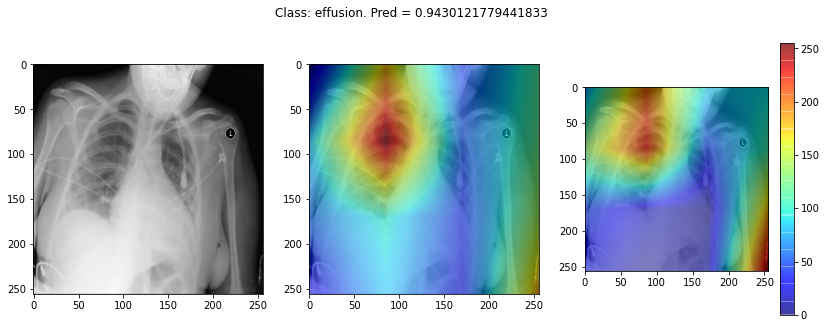

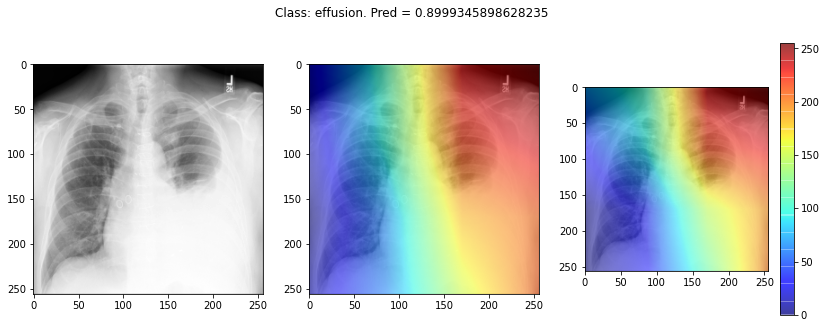

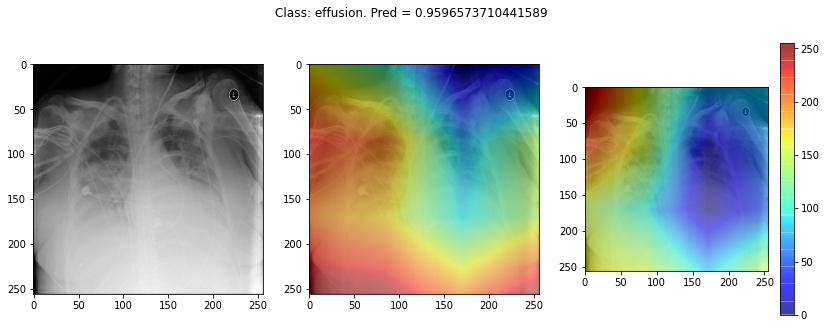

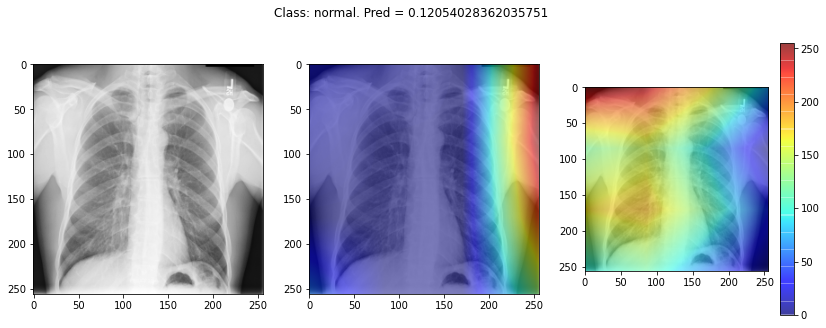

In [43]:
def plot_map2(cam1, cam2, classe, prediction, img):
    """
    Plot the image.
    """
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    axes[0].imshow(np.squeeze(img), cmap='gray')
    axes[1].imshow(np.squeeze(img), cmap='gray')
    axes[2].imshow(np.squeeze(img), cmap='gray')
    heatmap1 = np.uint8(cm.jet(cam1[0])[..., :3] * 255)
    heatmap2 = np.uint8(cm.jet(cam2[0])[..., :3] * 255)
    i = axes[1].imshow(heatmap1, cmap="jet", alpha=0.5)
    j = axes[2].imshow(heatmap2, cmap="jet", alpha=0.5)
    fig.colorbar(i)
    plt.suptitle("Class: {}. Pred = {}".format(classe, prediction))

# Plot each image with accompanying saliency map
for image_id in range(10):
    SEED_INPUT = dataset_test[image_id]
    CATEGORICAL_INDEX = [0]

    layer_idx = 18
    penultimate_layer_idx = 13
    class_idx  = 0

    cat_score = labels_test[image_id]
    cat_score = CategoricalScore(CATEGORICAL_INDEX)
    cam = gradcam(cat_score, SEED_INPUT, 
                  penultimate_layer = penultimate_layer_idx,
                  normalize_cam=True)
    cam2 = scorecam(cat_score, SEED_INPUT, 
                  penultimate_layer = penultimate_layer_idx,
                  normalize_cam=True
                  )
    
    # Display the class
    _class = 'normal' if labels_test[image_id] == 0 else 'effusion'
    _prediction = best_model.predict(dataset_test[image_id][np.newaxis, : ,...], verbose=0)
    
    plot_map2(cam, cam2, _class, _prediction[0][0], SEED_INPUT)

Notes:
==========Links to other courses in this series==========
https://carpentries-incubator.github.io/machine-learning-novice-python/ <- Intro to ML
https://carpentries-incubator.github.io/machine-learning-trees-python/ <- Intro to tree based methods
---This course goes here---  <- Intro to neural nets
https://carpentries-incubator.github.io/machine-learning-responsible-python/ <- Responsible machine learning
================================================


==========YouTube Links=========
What is a convolution https://www.youtube.com/watch?v=KuXjwB4LzSA
Intro to Neural Nets https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi
===============================

